# Analysing MNIST
To gain a deeper understanding of a particular dataset it is often a good strategy to analyse it using unsupervised methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## Sorting the data

Download the MNIST dataset, getting features X and labels y:

In [2]:
X, y = fetch_openml('mnist_784', return_X_y=True)

Create a NumPy array and analyse the shape of the data:

In [3]:
X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Image shape: {X[0].shape}")

X shape: (70000, 784), y shape: (70000,)
Image shape: (784,)


From the shape we can see that we have the full MNIST dataset of 70000 hand written didgets. 

They are yet to be split into a training and testing set and each image has been flattened to a (784,) array rather than the standard (28,28) form.

We will need to create a train, validation and test set before we proceed using SKlearns `train_test_split`.

In [4]:
# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# remove a validation set from the training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [5]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(70000, 784)
(44800, 784)
(11200, 784)
(14000, 784)


Now we can train the data and analyse using the validation set before testing on the test set. This will allow us to minimise overfitting by ensuring our model generalises well.

Later on we shall use cross-validation on the entire training set to ensure maximum generalisation, but for now we shall use the the validation set for this.

## Principle Component Analysis (PCA)

### Dimensionality reduction

Dimensionality reduction allows you to map a high dimension space into a lower dimension space. Principle component analysis does this by calculating the vector which maximise the variance in the data. This is the principle component and the next most varied is orthogonal to this and so on.

We shall fit the training data using PCA:

In [9]:
pca = PCA()
pca.fit(X_train)

PCA()

Now we can look at the principle components using the `components_` attribute:

In [10]:
print(pca.components_)
pca.components_.shape

[[ 3.83692361e-19  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.11645536e-19 -0.00000000e+00  5.55111512e-17 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-4.43896516e-19  0.00000000e+00  8.32667268e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00 -5.14907090e-01 -1.86330549e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.12111504e-01  2.71662851e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00  1.33881805e-02 -2.19162914e-02 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]]


(784, 784)

This has calculated a principle component for each of the features in the dataset (784)

We can see how much each component contributes to the overall variance in the data using the `explained_variance_ratio_` attribute:

In [13]:
explained_var_ratio = pca.explained_variance_ratio_
print(explained_var_ratio[:20], "...")

[0.09741741 0.07169639 0.06090458 0.05427341 0.04908907 0.04268909
 0.03287529 0.02894518 0.02746722 0.02334349 0.02109082 0.02046166
 0.01707323 0.01683221 0.01585105 0.01489277 0.01317229 0.01275316
 0.01195335 0.01145627] ...


Due to the large number of features it is hard to make sense of the data, but they have been ordered from most varied to least. 

We shall extract the first 10 components and see how much they contribute to the data's variance:

In [9]:
top_var = explained_var_ratio[:10]
print(top_var)
print(f"Variance for top 10 principle components: {top_var.sum():2f}")

[0.096961   0.07173243 0.06126736 0.05415579 0.049206   0.04304673
 0.03280572 0.02891221 0.02760799 0.02362902]
Variance for top 10 principle components: 0.489324


We can see the top 10 principle components contribute to almost half of the variance across all the features.

We shall now plot the cumulative sum of adding each principle component:

<function matplotlib.pyplot.show(close=None, block=None)>

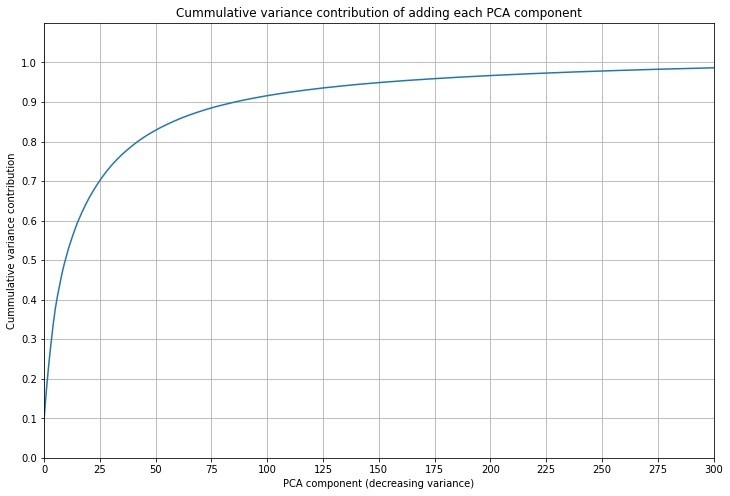

In [10]:
cumsum_var_ratio = np.cumsum(explained_var_ratio)
xs = np.arange(len(cumsum_var_ratio))

# beautify this!
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Cummulative variance contribution of adding each PCA component")
ax.set_xlabel("PCA component (decreasing variance)")
ax.set_ylabel("Cummulative variance contribution")
ax.grid()
ax.set_xticks(np.arange(0, len(cumsum_var_ratio), 25))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim(xmin=0, xmax=300)
ax.set_ylim(ymin=0, ymax=1.1)
ax.plot(xs, cumsum_var_ratio)
plt.show()

Here only the first 300 components have been plotted to get a clearer view of the components with the most variance.

As discussed earlier the first 10 components contribute to around 50% of the variance, this increases to 70% with 25 components and starts leveling off with around 25 components.

Depending on accuracy vs. minimusing components around 25-75 components should be enough to retain data whilst minimising dimenionality.

We shall try to reconstruct some MNIST images using only a subset of the principle components:

In [12]:
pca_50 = PCA(n_components=50)

deconstructed_50 = pca_50.fit_transform(X_train)
reconstructed_50 = pca_50.inverse_transform(deconstructed_50)
reconstructed_50.shape

(44800, 784)

We can create a function to compare n images to their reconstructions as follows:

In [15]:
def plot_reconstructed(plot_imgs, plot_reconstructed_imgs, num=5):
    fig = plt.figure(figsize=(12, 8))
    # get random indices
    indices = np.random.choice(len(imgs), num)
    # show (num) test iamges
    for i, ind in enumerate(indices):
            ax = fig.add_subplot(1, num+1, i+1)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.imshow(imgs[ind], cmap='gray')
    # show (num) reconstructed images
    for i, ind in enumerate(indices):
            ax = fig.add_subplot(2, num+1, i+num+2)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.imshow(reconstructed_imgs[ind], cmap='gray')

50 Components (~85% variance):


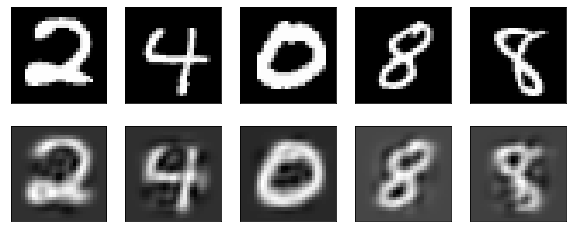

In [16]:
imgs = X_train.reshape(-1, 28, 28)
reconstructed_imgs = reconstructed_50.reshape(-1, 28, 28)

print("50 Components (~85% variance):")
plot_reconstructed(imgs, reconstructed_imgs)

The patterns in the data have been retained well. This is not too suprising given the simplicity of the data - this might not be the case for larger images.

Let's see what happens when we reduce the number of components further:

In [17]:
def pca_reduce_img(X, n):
    pca = PCA(n_components=n)
    deconstructed = pca.fit_transform(X)
    reconstructed = pca.inverse_transform(deconstructed)
    return reconstructed.reshape(-1, 28, 28)

reconstructed_25 = pca_reduce_img(X_train, 25)
reconstructed_10 = pca_reduce_img(X_train, 10)
reconstructed_5 = pca_reduce_img(X_train, 5)

25 Componenets (~70% variance):
10 Componenets (~50% variance):
10 Componenets (~30% variance):


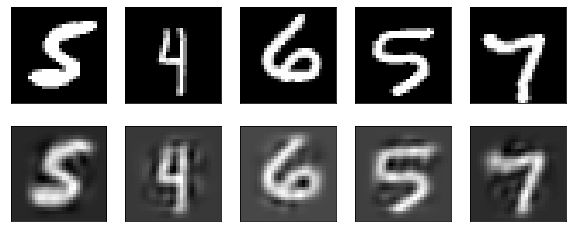

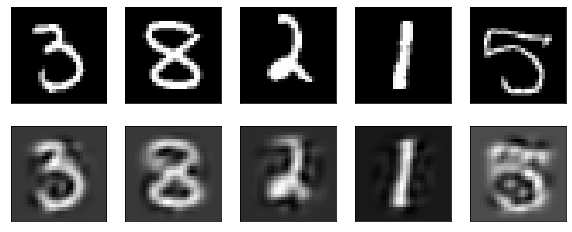

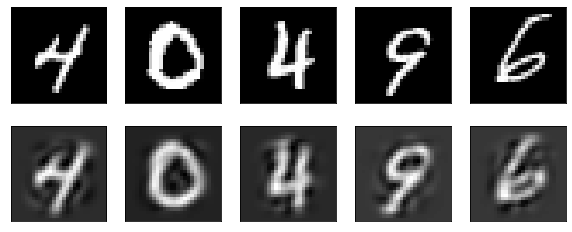

In [18]:
print("25 Componenets (~70% variance):")
plot_reconstructed(imgs, reconstructed_25)
plt.show()

print("10 Componenets (~50% variance):")
plot_reconstructed(imgs, reconstructed_10)
plt.show()

print("10 Componenets (~30% variance):")
plot_reconstructed(imgs, reconstructed_5)
plt.show()

Reconstructing with 25 components still produces reasonably clear images, but this still maintains 70% of the variance so this is not suprising. What is superising is that reconstructing with only 3% the number of features as before produces good results.

Reducing further to 10 and 5 components results in images which have most of their original information and are not easily recognisable. This does not nescasarily mean a classifier would do a bad job on them though.

### Visualisation

Reducing further does have an important use though; visualisation! Reducing down to 2 features means we can visualise the data easily so let's do that:

In [21]:
pca_2 = PCA(n_components=2)
X_train_2 = pca_2.fit_transform(X_train)

X_train_2.shape

(44800, 2)

As expected we now have the training set reduced to just 2 dimensions. 

We can use this to visualise the MNIST dataset and see how PCA has maximised the variance:

In [22]:
def plt_2d_mnist(X, y, title):
    xs, ys = X[:,0], X[:,1]
    c = np.array(y).astype('int')
    fix, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(title)
    ax.scatter(xs, ys, c=c, cmap="tab10", s=1, alpha=0.5)
    plt.show()

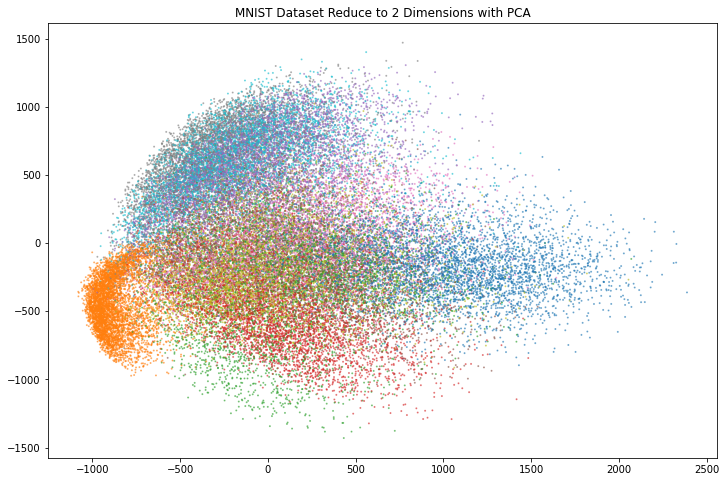

In [23]:
plt_2d_mnist(X_train_2, y_train, "MNIST Dataset Reduce to 2 Dimensions with PCA")

Looking at the scatter plot we can see some separability between the classes, but it is still difficult to see any obvious boundaries between them.

As the data is seemingly non separable we should try using a kernel. This will map the data into higher dimensional space before performing dimensionality reduction allowing for a complex non linear projections into lower dimensional space.

We shall try the radial basis function (RBF) kernel:

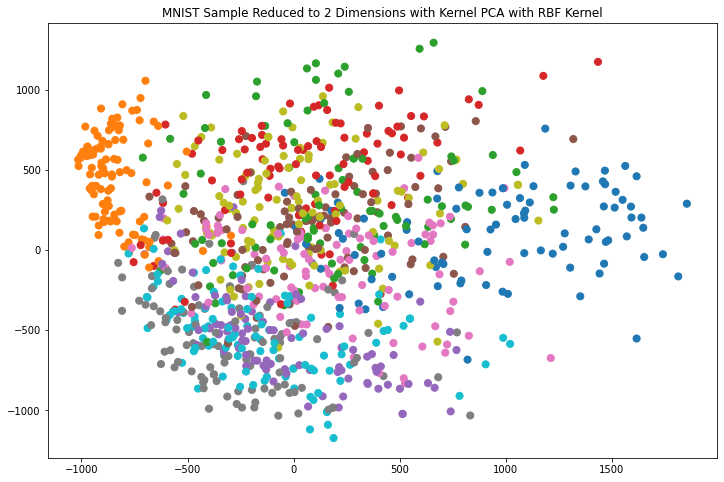

In [24]:
rbf_pca = KernelPCA(n_components=2, kernel='linear')

samples = np.random.choice(len(X_train), 1000)
Xsamples = X_train[samples]
ysamples = y_train[samples]
samples_reduced = rbf_pca.fit_transform(Xsamples)

xs, ys = samples_reduced[:,0], samples_reduced[:,1]
c = np.array(ysamples).astype('int')
fix, ax = plt.subplots(figsize=(12, 8))
ax.set_title("MNIST Sample Reduced to 2 Dimensions with Kernel PCA with RBF Kernel")
ax.scatter(xs, ys, c=c, cmap="tab10", s=50, alpha=1)
plt.show()

KernelPCA uses a lot of memory and so I was unable to fit the entire dataset. Applying it to 100 random samples let's us see how it would have performed should the whole dataset have worked. We can see there is not really much more seperability than the 'linear' PCA so continuing samples would not give better results.

A better method for visualising high dimension data is t-distributed stochastic neighbor embedding (TSNE). We shall use PCA to reduce the dimensionality of the data to 20 features and then use TSNE to reduce further down to 2 features for visualisation.


In [25]:
pca_20 = PCA(n_components=10)
X_train_20 = pca_20.fit_transform(X_train)

In [26]:
tsne = TSNE()
X_train_tsne_2 = tsne.fit_transform(X_train_20)

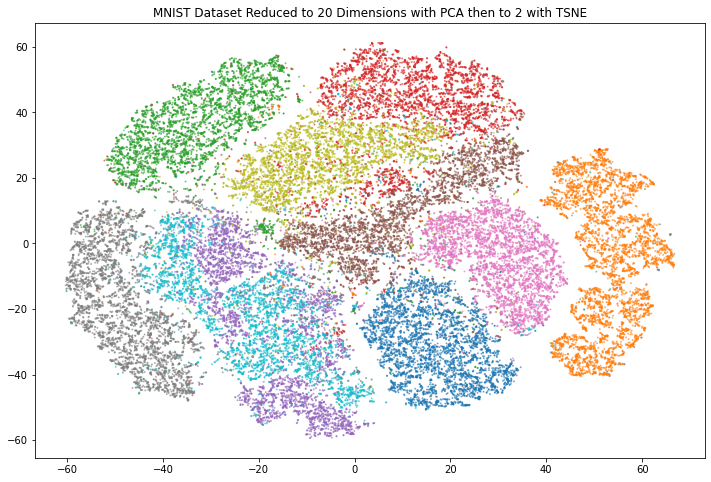

In [27]:
plt_2d_mnist(X_train_tsne_2, y_train, "MNIST Dataset Reduced to 20 Dimensions with PCA then to 2 with TSNE")

This has worked a lot better in separating the different classes. Although it is still not perfect, it has managed to cluster the classes quite well.

The general way t-SNE works is by reducing dimensionality whilst keeping similar instances close and moving differing instances away from eachother.

## 2.1.2 K-Means

K-Means is a method of clustering which attempts to cluster the given data into K classes. It works by setting K random points as the cluster centroids, then assigning each of the data points to their nearest cluster. The centroid locations are then updated to that of the mean of their assigned data points positions. The datapoints are then reassigned to their closest and the centroids updated again. This repeats until convergence (no movement between repeats).

We shall apply kmeans to the first two principle components found earlier with PCA to get the centroid locations.

In [28]:
kmeans = KMeans(n_clusters=10)
kmeans.fit_predict(X_train_2)

# centroids = kmeans.cluster_centers_
print(kmeans.cluster_centers_)

[[-523.15447065   19.0555405 ]
 [ 653.43224307 -195.37458432]
 [-328.54666008  526.33919069]
 [  91.32776716  -37.77692255]
 [-204.31267518 -455.74677861]
 [1340.12618677 -205.24485873]
 [-855.2607347  -464.65145369]
 [  68.15607057  846.98693501]
 [ 324.99382745 -715.43784033]
 [ 486.61339532  443.2155321 ]]


Now we have our 10 centroid locations, we can plot them on the earlier visualisation and see where they fall.

In [15]:
def plot_veronoi(X, y, kmeans):
    """
    Plot veronoi diagram with data given KMeans centroids
    """
    xs, ys = X[:,0], X[:,1]
    x_min, x_max = xs.min()-1, xs.max()+1
    y_min, y_max = ys.min()-1, ys.max()+1

    centroids = kmeans.cluster_centers_

    # generate veronoi boundaries for plotting
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, int(10*(x_max-x_min))),
                         np.linspace(y_min, y_max, )))
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10*(max-min)), np.linspace(y_min, y_max, 10*(max-min)))
    # Obtain labels for each point in mesh. Use last trained model.
    # Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    
    plt.figure(figsize=(12,8))
    # plot veronoi
    plt.imshow(Z, interpolation='nearest', 
               extent=(xx.min(), xx.max(), yy.min(), yy.max()), 
               cmap="Pastel1",
               aspect='auto', 
               origin='lower')
    # plot data and centroids
    plt.scatter(xs, ys, color='black', s=0.1, alpha=1)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='black', s=100, linewidths=2, zorder=10)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

In [ ]:
plot_veronoi(X_train_2, y_train, kmeans)

- talk about veronoi
